https://www.kaggle.com/code/doggypiggy/store-sales-getting-started-with-time-series/notebook

Resultado supuesto 0.40 

Resultado real 0.57 

## Store Sales - Getting Started with Time Series

#### Thanks for checking out my Notebook! Feel free to copy and edit on you own : )

#### Getting started with Time Series might seem *overwhelming* with so many new concepts.

#### I made this notebook to illustarte a simple work flow for solving a typical Time Series problem.

#### The solution is mostly taken from [Andrej Marinchenko](https://www.kaggle.com/code/andrej0marinchenko/hyperparamaters), [BIZEN](https://www.kaggle.com/code/hiro5299834/store-sales-ridge-voting-bagging-et-bagging-rf), and [KDJ2020](https://www.kaggle.com/code/dkomyagin/simple-ts-ridge-rf/notebook).

#### I clenaed up their code and reformated some plots to make the notebook shorter and easier to read.

#### If it's helpful to your learning process, please upvote so that more people can see it.

#### All comments and feedbacks are welcome!

#### If you need more explanations about some theories, feel free to check out this [Kaggle Course](https://www.kaggle.com/learn/time-series).

#### Note: it will take a bit more than 30 minutes to run the entire notebook.

# Setting Things Up

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rcParams, style
import seaborn as sns
from plotly import express as px, graph_objects as go
rcParams['figure.figsize'] = (10, 6)

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

import gc
gc.enable()
from warnings import filterwarnings, simplefilter
filterwarnings('ignore')
simplefilter('ignore')

# Train and Test Data

In [2]:
path='../Datasets/store-sales-time-series-forecasting/'
train = pd.read_csv(path+'train.csv',
                    parse_dates = ['date'], infer_datetime_format = True,
                    dtype = {'store_nbr' : 'category',
                             'family' : 'category'},
                   usecols = ['date', 'store_nbr', 'family', 'sales'])

train['date'] = train.date.dt.to_period('D')
train = train.set_index(['date', 'store_nbr', 'family']).sort_index()
train.head()

sales
date       store_nbr family           
2013-01-01 1         AUTOMOTIVE    0.0
                     BABY CARE     0.0
                     BEAUTY        0.0
                     BEVERAGES     0.0
                     BOOKS         0.0

In [3]:
test = pd.read_csv(path+'test.csv',
                   parse_dates = ['date'], infer_datetime_format = True)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['date', 'store_nbr', 'family']).sort_values('id')
test.head()

id  onpromotion
date       store_nbr family                          
2017-08-16 1         AUTOMOTIVE  3000888            0
                     BABY CARE   3000889            0
                     BEAUTY      3000890            2
                     BEVERAGES   3000891           20
                     BOOKS       3000892            0

# Oil Data

In [4]:
# Using the full date range
calendar = pd.DataFrame(index = pd.date_range('2013-01-01', '2017-08-31')).to_period('D')
oil = pd.read_csv(path+'oil.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')
oil['avg_oil'] = oil['dcoilwtico'].rolling(7).mean()
calendar = calendar.join(oil.avg_oil)
calendar['avg_oil'].fillna(method = 'ffill', inplace = True)
calendar.dropna(inplace = True)
calendar.head()

avg_oil
2013-01-10  93.218571
2013-01-11  93.284286
2013-01-12  93.284286
2013-01-13  93.284286
2013-01-14  93.470000

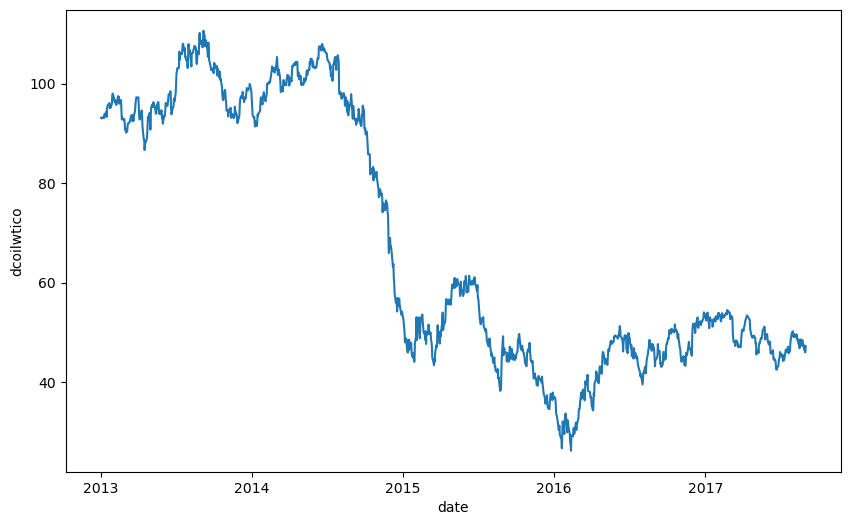

In [5]:
# Plotting oil price
_ = sns.lineplot(data = oil.dcoilwtico.to_timestamp())

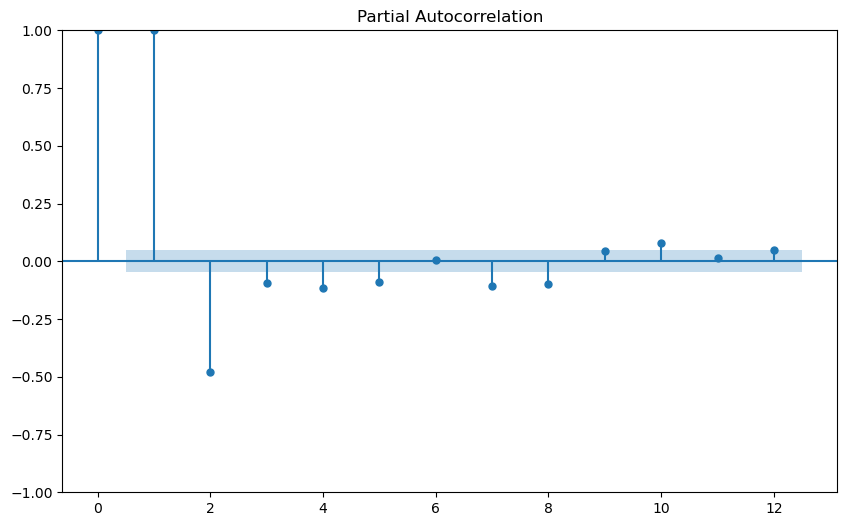

In [6]:
# Plotting the partial autocorrelation function
_ = plot_pacf(calendar.avg_oil, lags = 12)

In [7]:
# Adding lages based on the auto correlation plot above (up to 5 will be reasonable)
n_lags = 3
for l in range(1, n_lags + 1) :
    calendar[f'oil_lags_{l}'] = calendar.avg_oil.shift(l)
calendar.dropna(inplace = True)
calendar.head()

avg_oil  oil_lags_1  oil_lags_2  oil_lags_3
2013-01-13  93.284286   93.284286   93.284286   93.218571
2013-01-14  93.470000   93.284286   93.284286   93.284286
2013-01-15  93.490000   93.470000   93.284286   93.284286
2013-01-16  93.644286   93.490000   93.470000   93.284286
2013-01-17  93.970000   93.644286   93.490000   93.470000

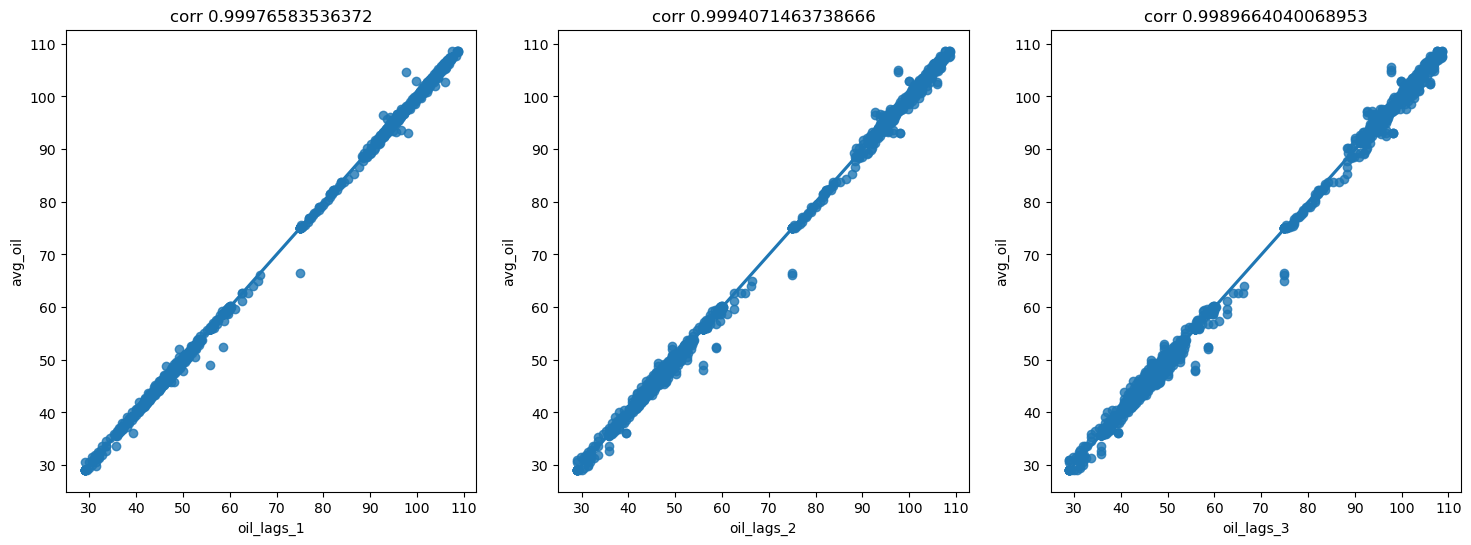

In [8]:
# Checking the correlation plot with different lags
lag1, lag2, lag3 = 'oil_lags_1', 'oil_lags_2', 'oil_lags_3'

fig = plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.regplot(x = calendar[lag1], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag1])}')
plt.subplot(1,3,2)
sns.regplot(x = calendar[lag2], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag2])}')
plt.subplot(1,3,3)
sns.regplot(x = calendar[lag3], y = calendar.avg_oil)
plt.title(f'corr {calendar.avg_oil.corr(calendar[lag3])}');

# Holiday Data

In [9]:
hol = pd.read_csv(path+'holidays_events.csv',
                  parse_dates = ['date'], infer_datetime_format = True,
                  index_col = 'date').to_period('D')
hol = hol[hol.locale == 'National'] # Only taking National holiday so there's no false positive.
hol = hol.groupby(hol.index).first() # Removing duplicated holiday at the same date
hol.head()

type    locale locale_name  \
date                                         
2012-08-10   Holiday  National     Ecuador   
2012-10-09   Holiday  National     Ecuador   
2012-10-12  Transfer  National     Ecuador   
2012-11-02   Holiday  National     Ecuador   
2012-11-03   Holiday  National     Ecuador   

                                    description  transferred  
date                                                          
2012-08-10        Primer Grito de Independencia        False  
2012-10-09           Independencia de Guayaquil         True  
2012-10-12  Traslado Independencia de Guayaquil        False  
2012-11-02                      Dia de Difuntos        False  
2012-11-03              Independencia de Cuenca        False

In [10]:
# Feature Engineering
calendar = calendar.join(hol) # Joining calendar with holiday dataset
calendar['dofw'] = calendar.index.dayofweek # Weekly day
calendar['wd'] = 1
calendar.loc[calendar.dofw > 4, 'wd'] = 0 # If it's saturday or sunday then it's not workday
calendar.loc[calendar.type == 'Work Day', 'wd'] = 1 # If it's Work Day event then it's a workday
calendar.loc[calendar.type == 'Transfer', 'wd'] = 0 # If it's Transfer event then it's not a workday
calendar.loc[calendar.type == 'Bridge', 'wd'] = 0 # If it's Bridge event then it's not a workday
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == False), 'wd'] = 0 # If it's holiday and the holiday is not transferred then it's holiday
calendar.loc[(calendar.type == 'Holiday') & (calendar.transferred == True), 'wd'] = 1 # If it's holiday and transferred then it's not holiday
calendar = pd.get_dummies(calendar, columns = ['dofw'], drop_first = True) # One-hot encoding (Make sure to drop one of the columns by 'drop_first = True')
calendar = pd.get_dummies(calendar, columns = ['type']) # One-hot encoding for type holiday (No need to drop one of the columns because there's a "No holiday" already)
calendar.drop(['locale', 'locale_name', 'description', 'transferred'], axis = 1, inplace = True) # Unused columns
calendar.head()

avg_oil  oil_lags_1  oil_lags_2  oil_lags_3  wd  dofw_1  dofw_2  \
2013-01-13  93.284286   93.284286   93.284286   93.218571   0       0       0   
2013-01-14  93.470000   93.284286   93.284286   93.284286   1       0       0   
2013-01-15  93.490000   93.470000   93.284286   93.284286   1       1       0   
2013-01-16  93.644286   93.490000   93.470000   93.284286   1       0       1   
2013-01-17  93.970000   93.644286   93.490000   93.470000   1       0       0   

            dofw_3  dofw_4  dofw_5  dofw_6  type_Additional  type_Bridge  \
2013-01-13       0       0       0       1                0            0   
2013-01-14       0       0       0       0                0            0   
2013-01-15       0       0       0       0                0            0   
2013-01-16       0       0       0       0                0            0   
2013-01-17       1       0       0       0                0            0   

            type_Event  type_Holiday  type_Transfer  type_Work Day  
2013-01-13           0             0              0              0  
2013-01-14           0             0              0              0  
2013-01-15           0             0              0              0  
2013-01-16           0             0              0              0  
2013-01-17           0             0              0              0

# Visualization - Sales of Each Product

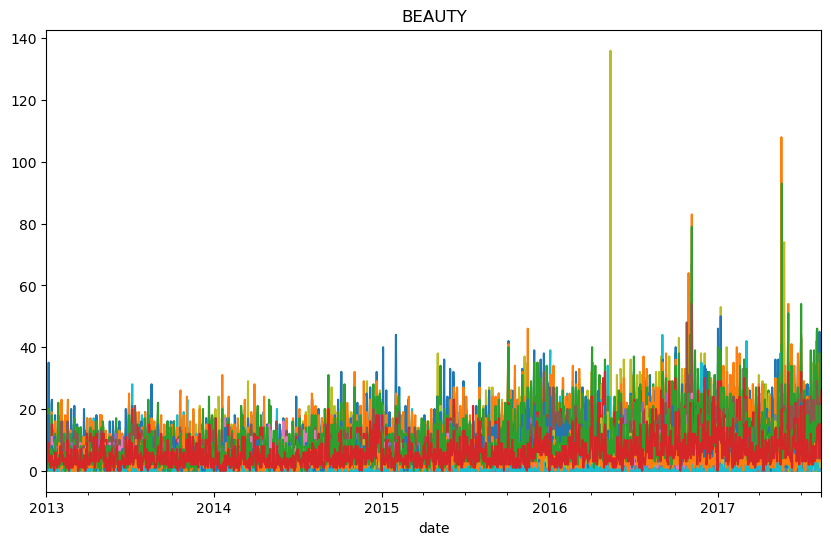

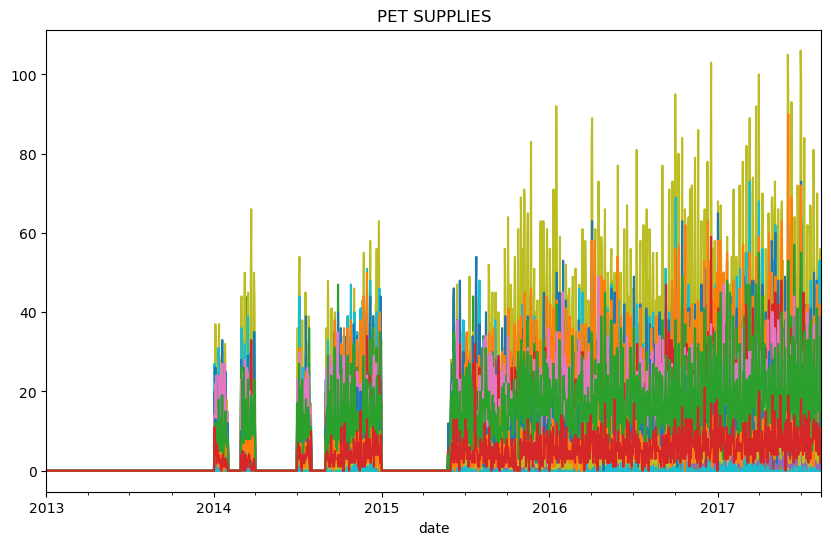

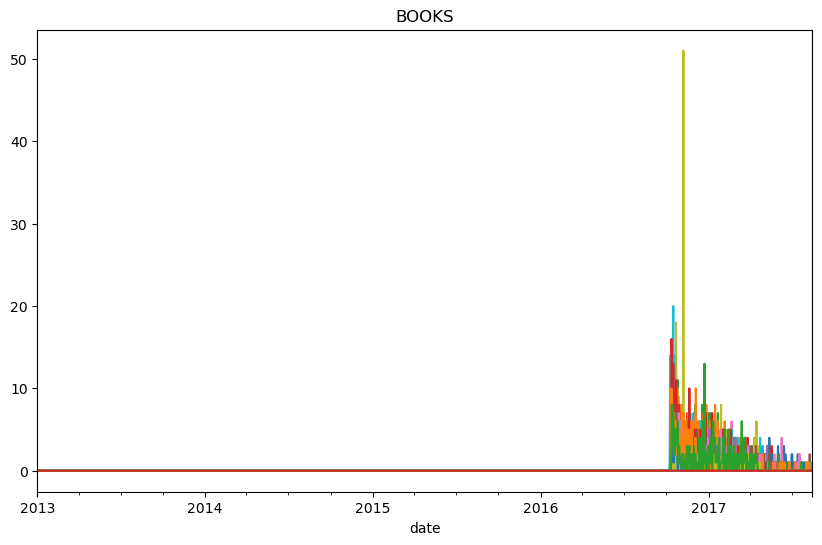

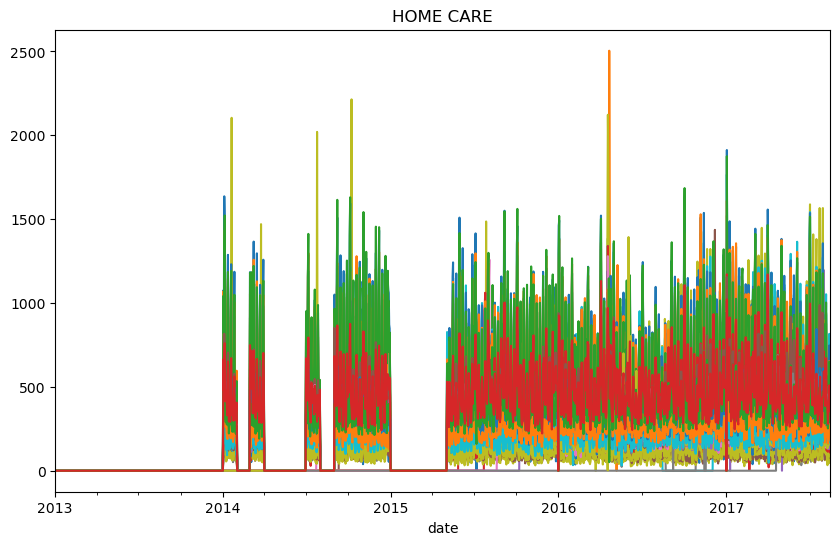

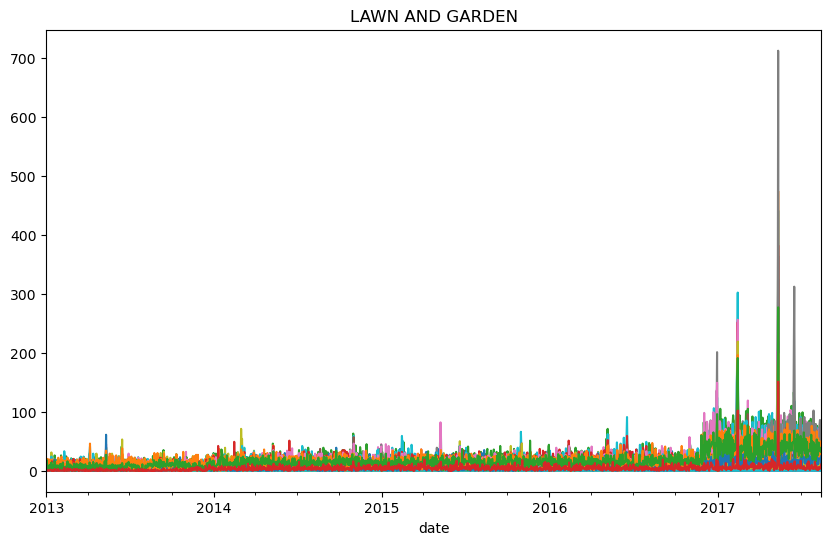

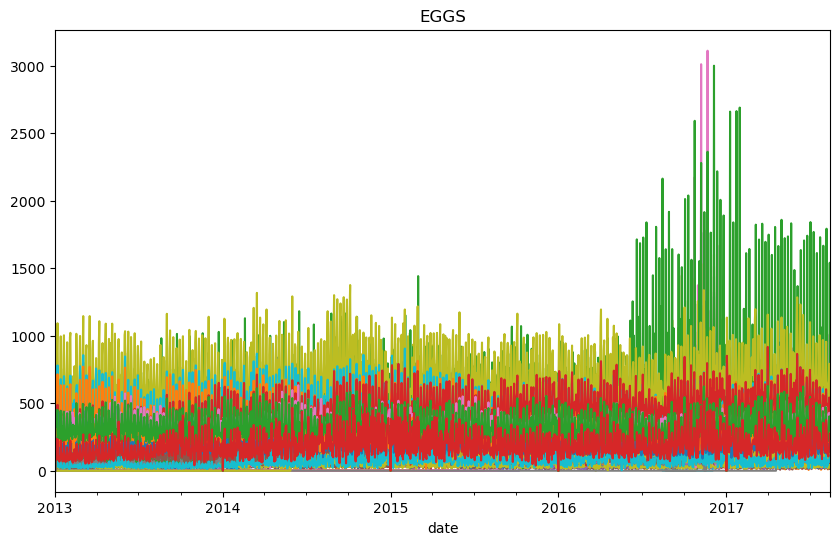

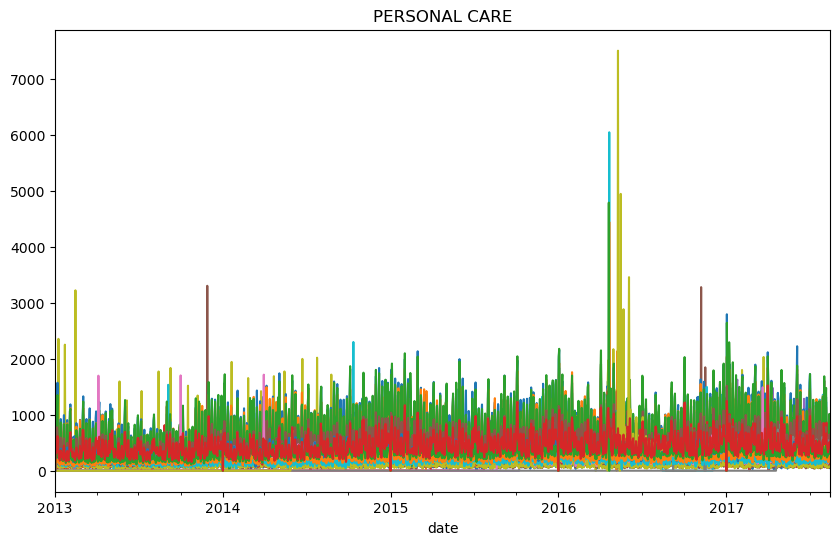

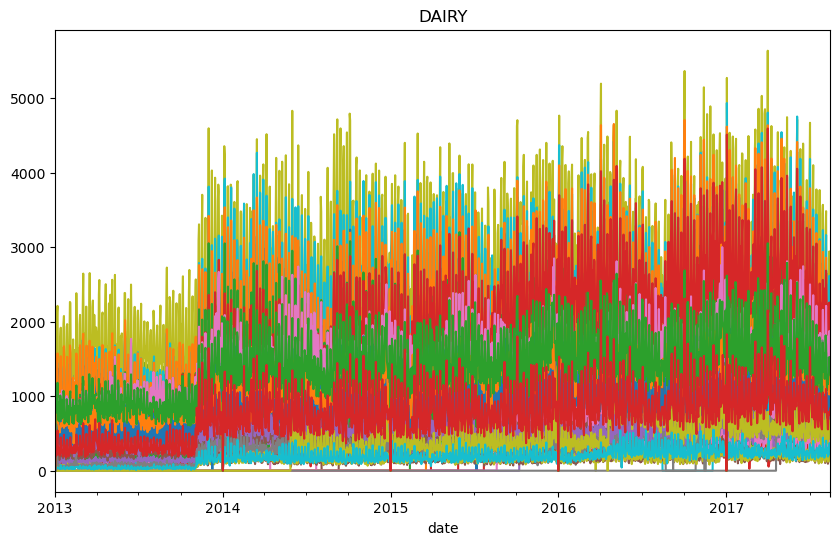

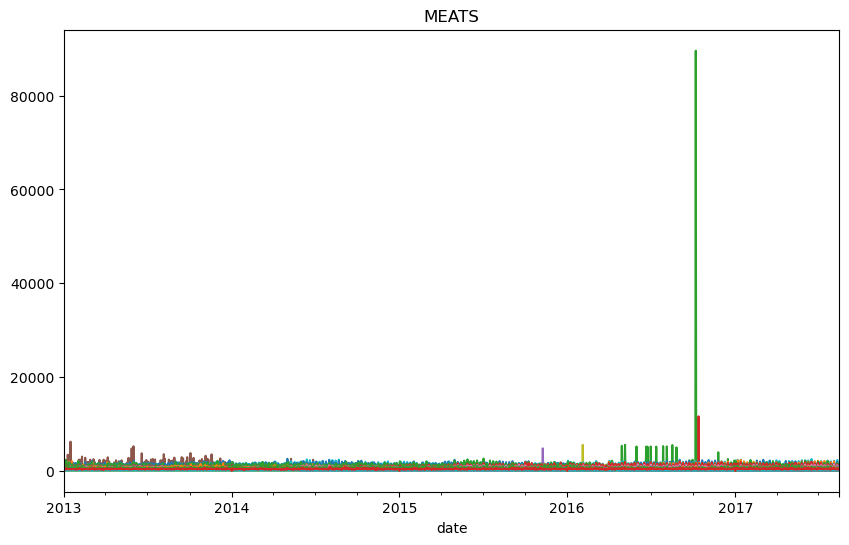

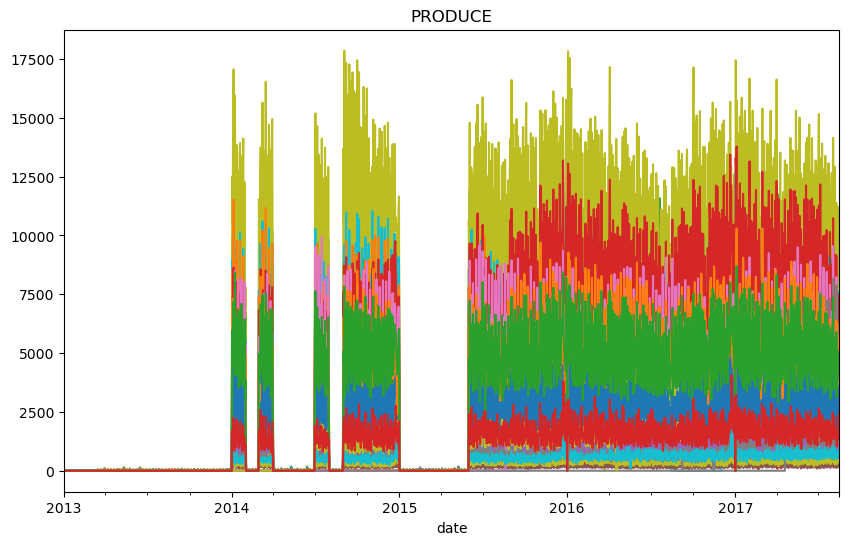

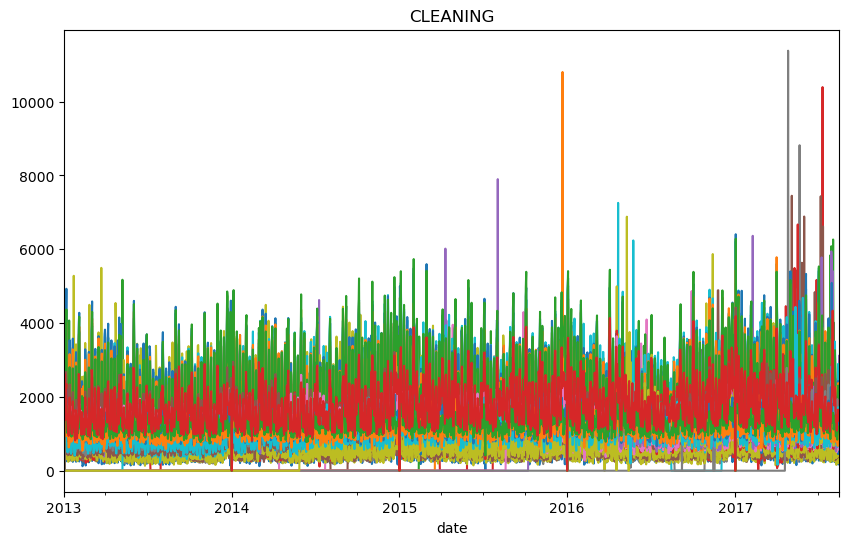

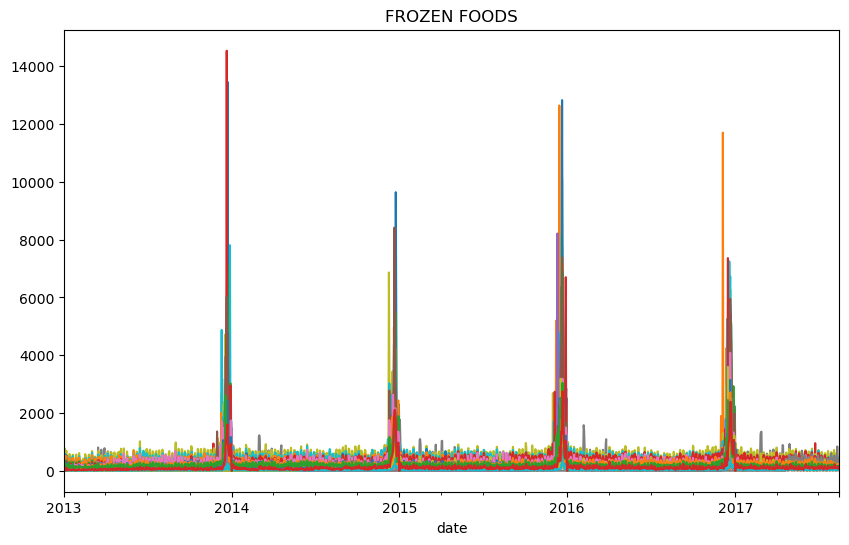

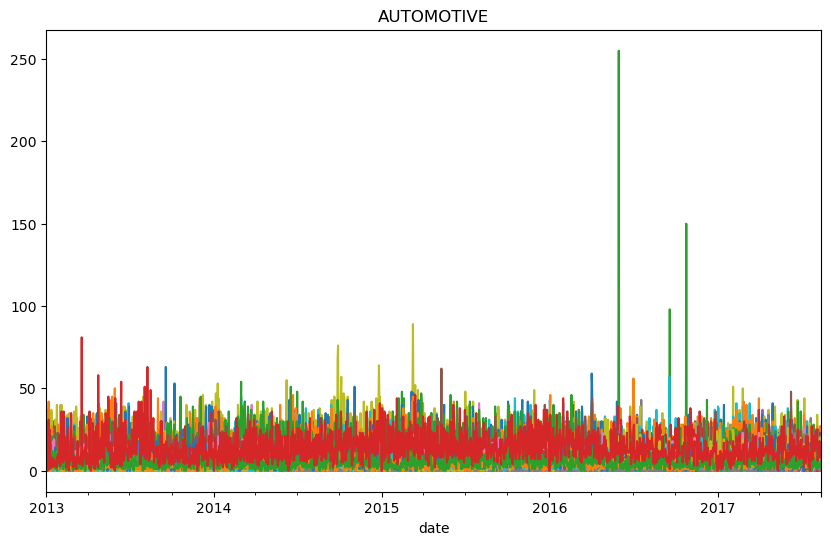

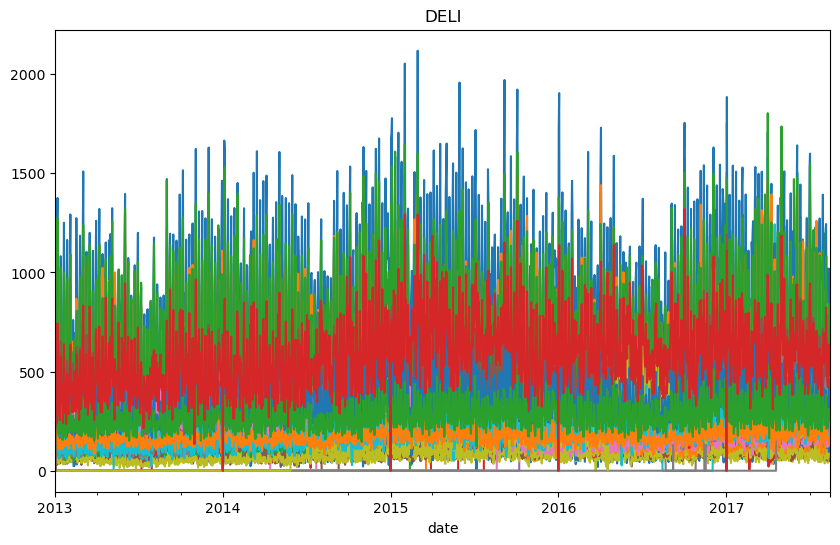

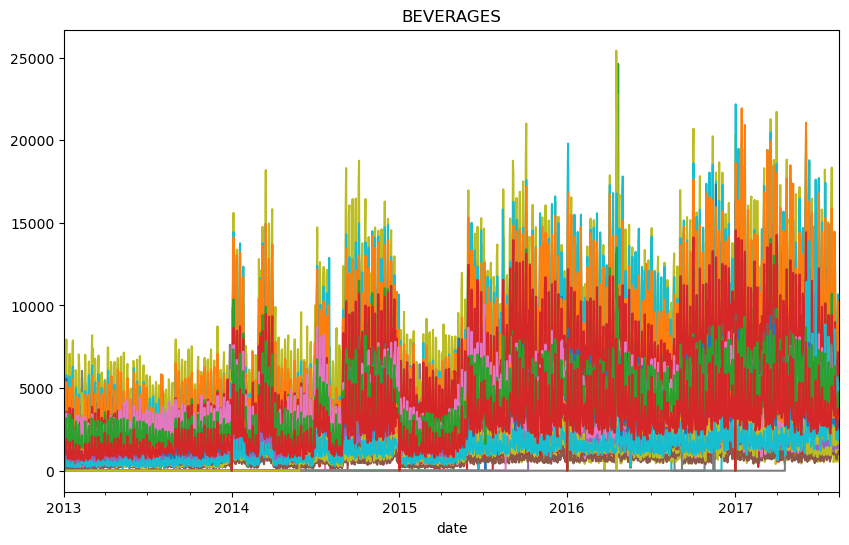

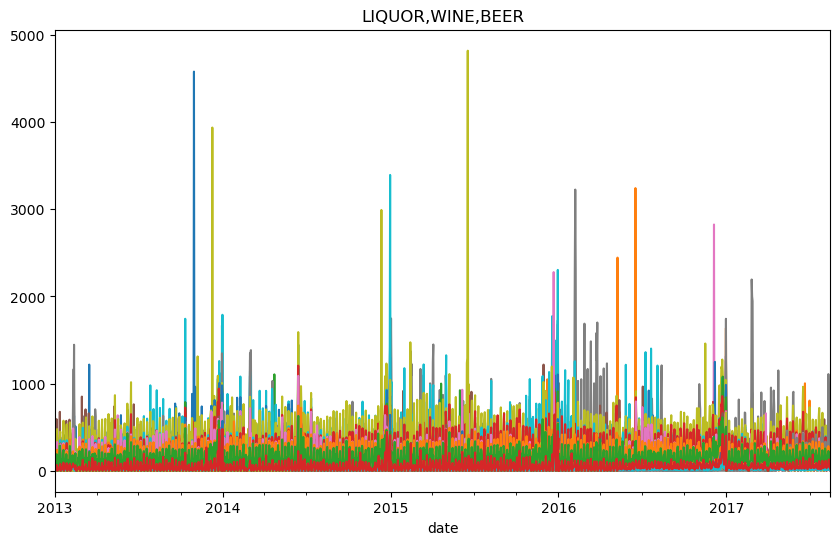

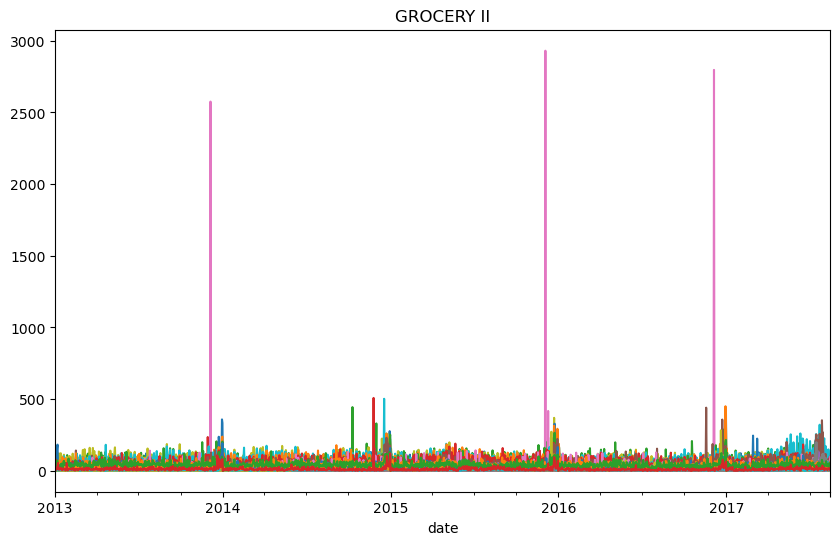

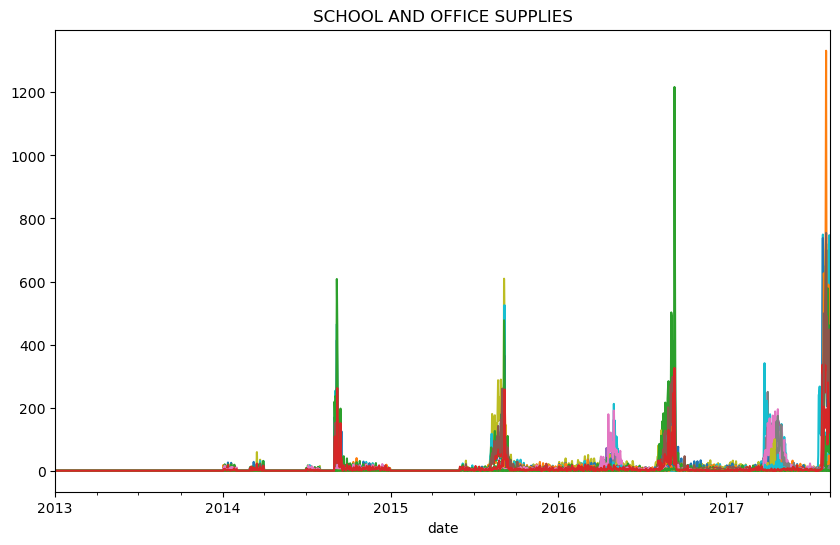

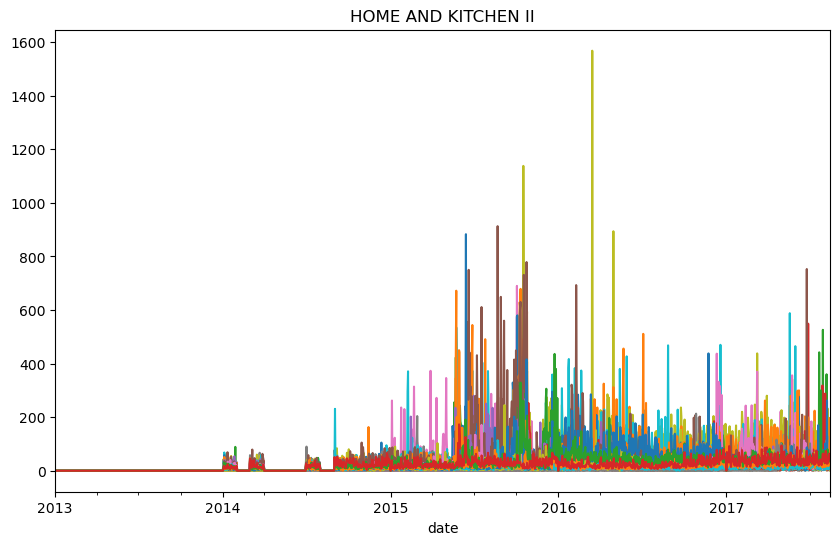

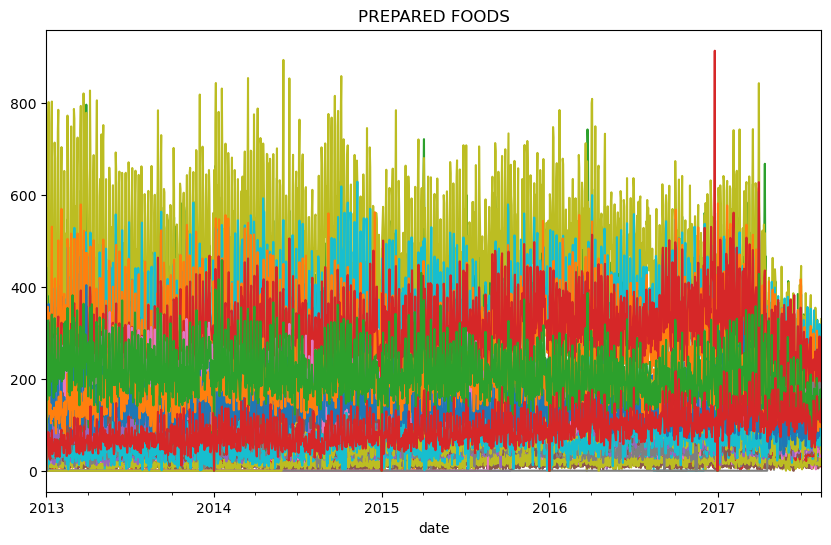

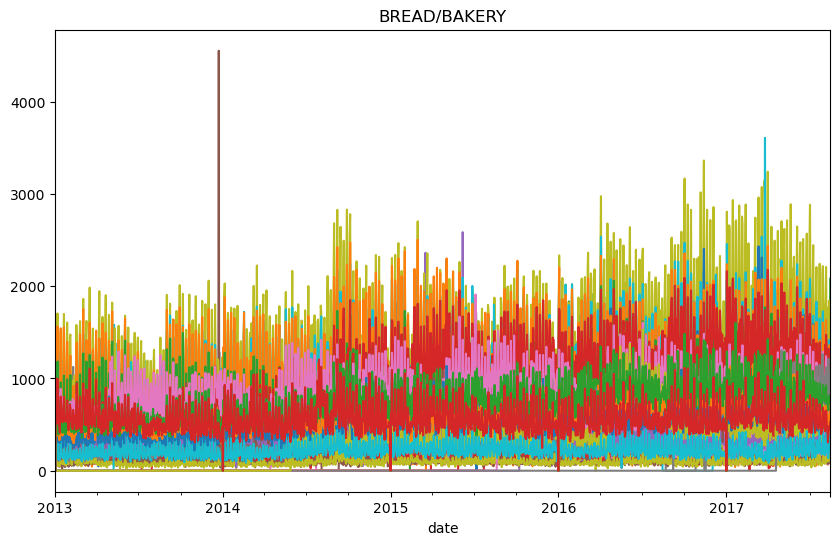

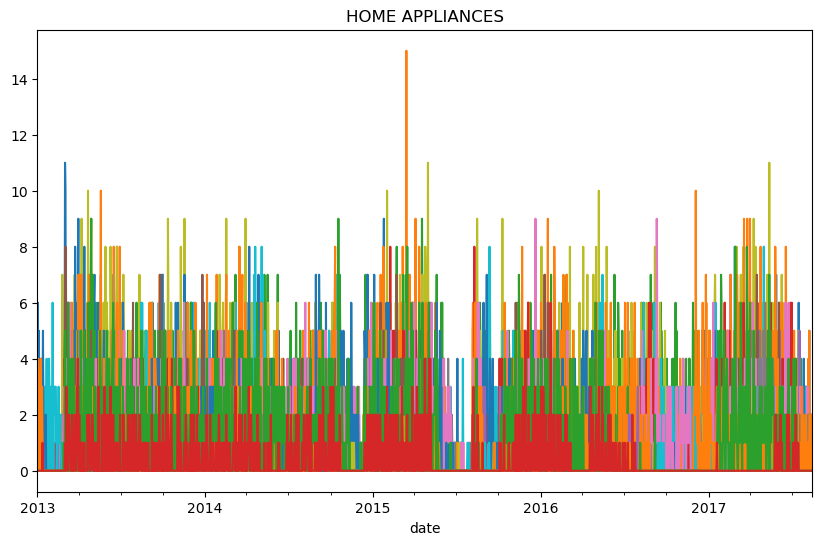

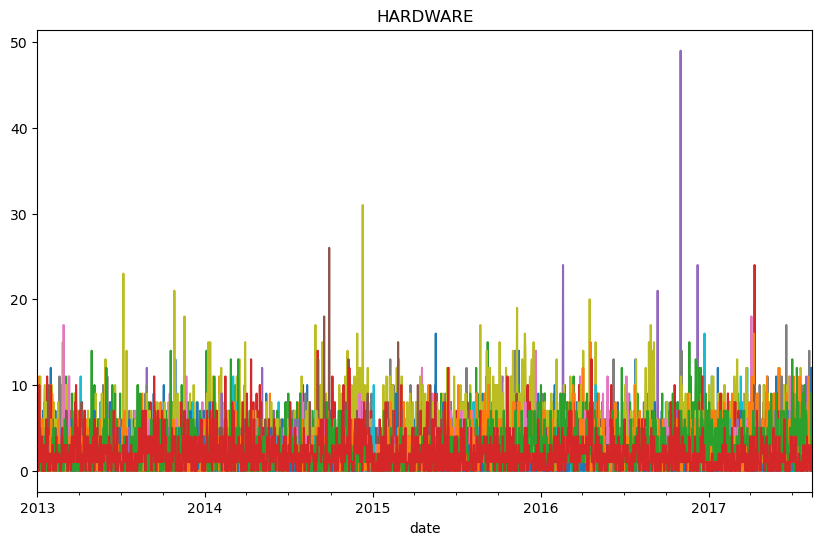

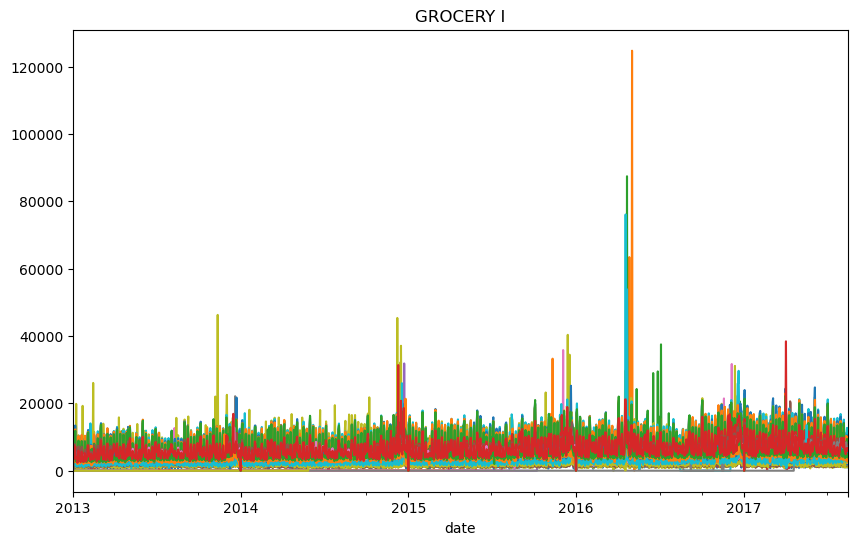

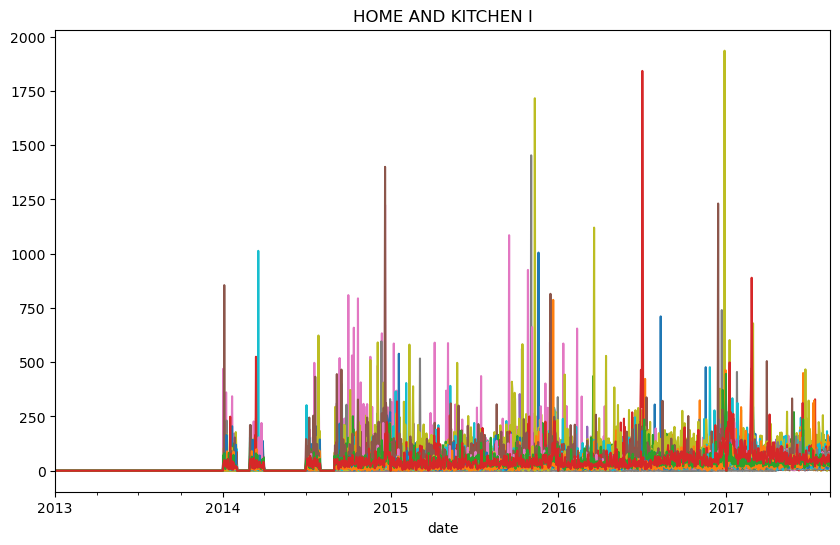

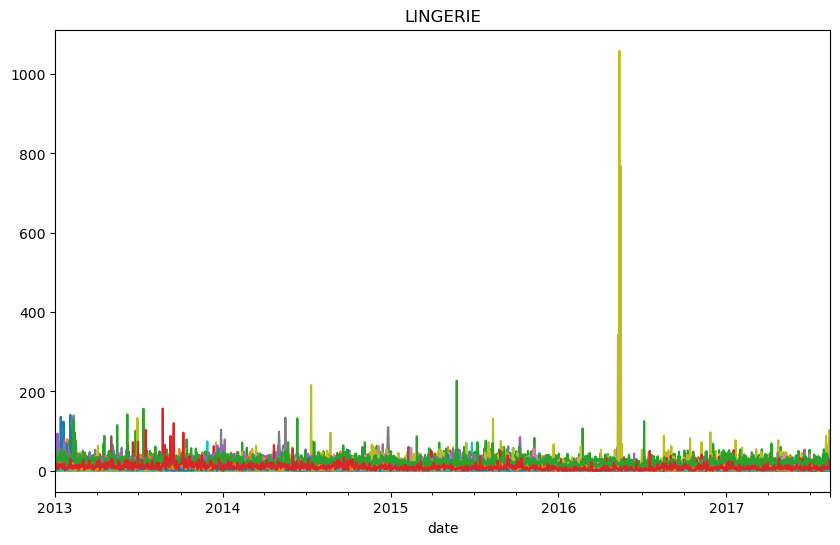

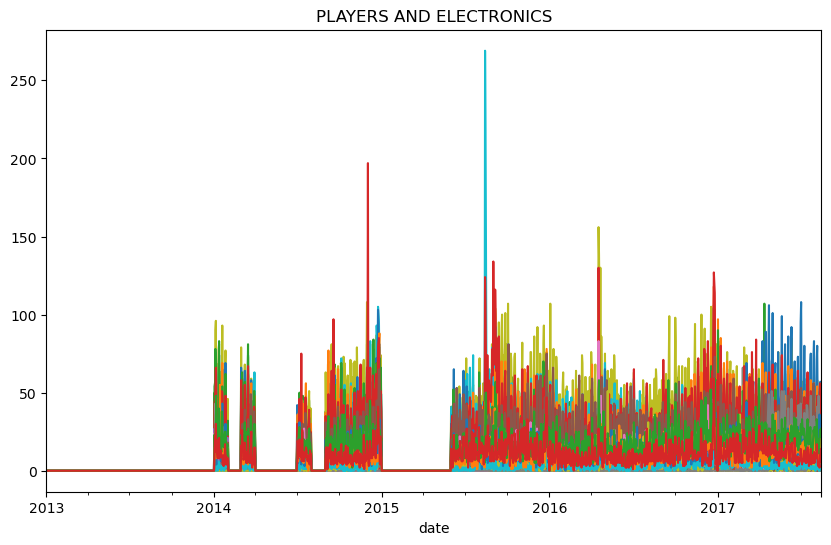

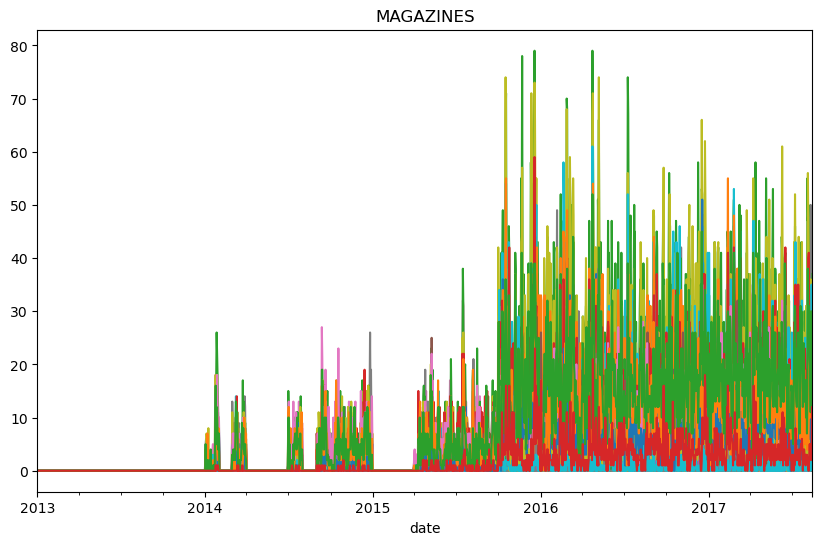

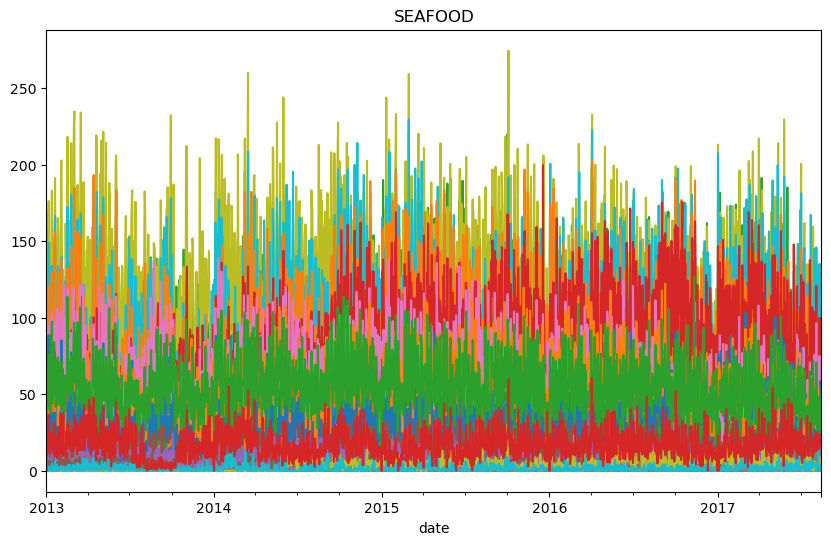

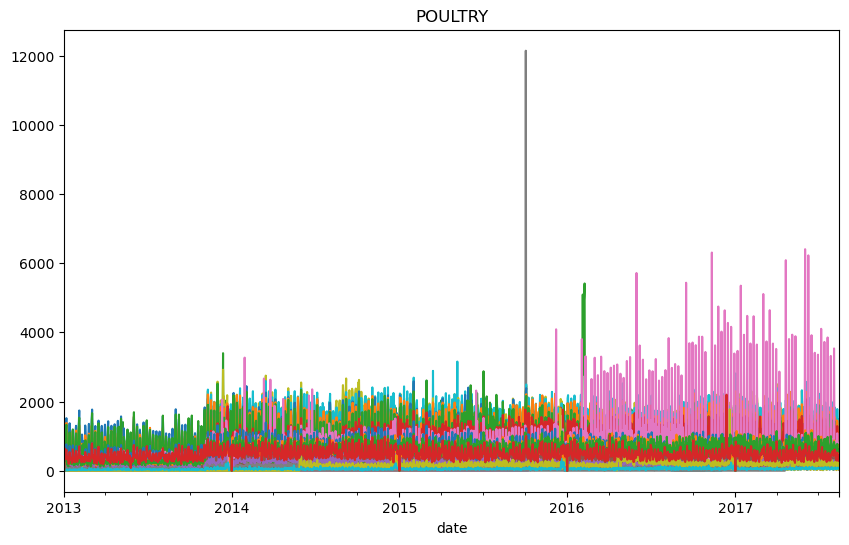

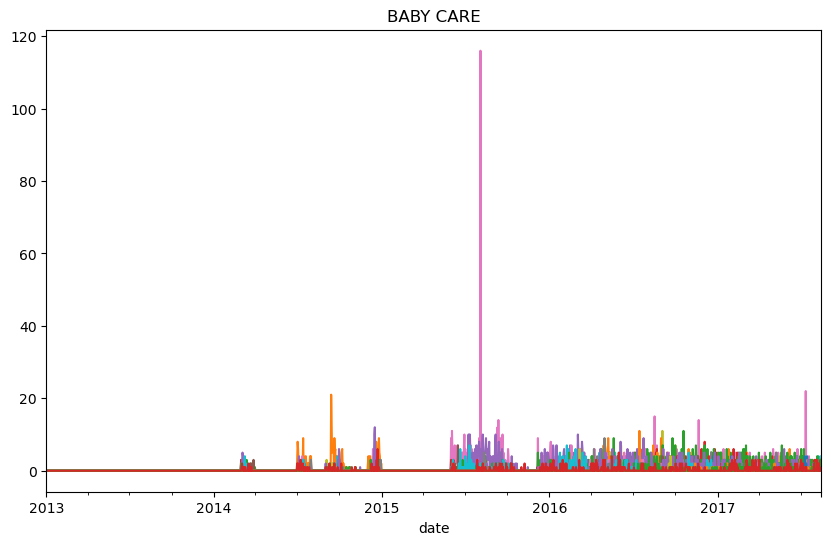

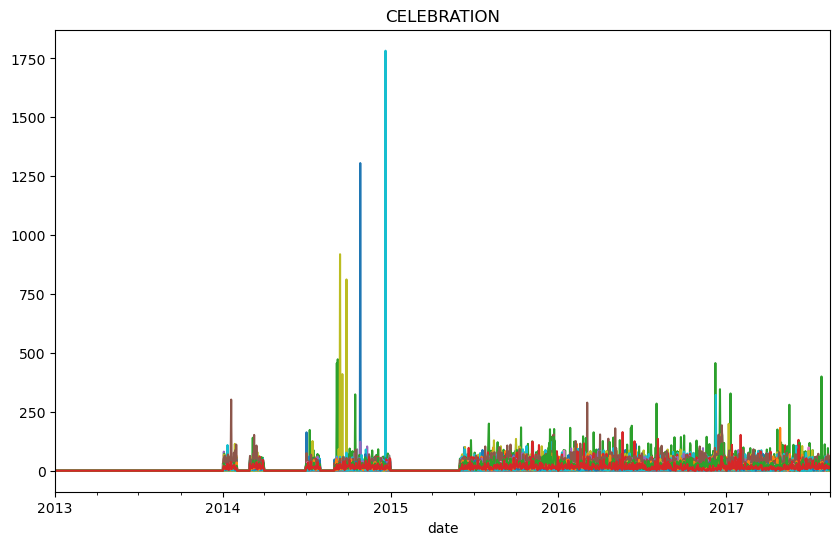

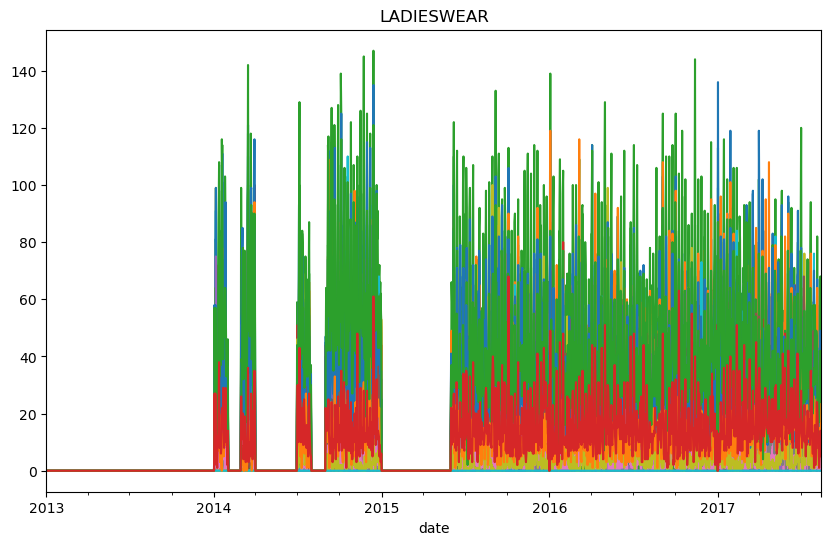

In [11]:
y = train.unstack(['store_nbr', 'family']).loc['2013':'2017']
family = {c[2] for c in train.index}
for f in family :
    ax = y.loc(axis = 1)['sales', :, f].plot(legend = None)
    ax.set_title(f)

# Defining the Training Date

In [12]:
# Start and end of training date (based on plots above)
sdate = '2017-04-30' 
edate = '2017-08-15'

In [13]:
# Adding a feature for school fluctuations
school_season = [] 
for i, r in calendar.iterrows() :
    if i.month in [4, 5, 8, 9] :
        school_season.append(1)
    else :
        school_season.append(0)
calendar['school_season'] = school_season
calendar.head()

avg_oil  oil_lags_1  oil_lags_2  oil_lags_3  wd  dofw_1  dofw_2  \
2013-01-13  93.284286   93.284286   93.284286   93.218571   0       0       0   
2013-01-14  93.470000   93.284286   93.284286   93.284286   1       0       0   
2013-01-15  93.490000   93.470000   93.284286   93.284286   1       1       0   
2013-01-16  93.644286   93.490000   93.470000   93.284286   1       0       1   
2013-01-17  93.970000   93.644286   93.490000   93.470000   1       0       0   

            dofw_3  dofw_4  dofw_5  dofw_6  type_Additional  type_Bridge  \
2013-01-13       0       0       0       1                0            0   
2013-01-14       0       0       0       0                0            0   
2013-01-15       0       0       0       0                0            0   
2013-01-16       0       0       0       0                0            0   
2013-01-17       1       0       0       0                0            0   

            type_Event  type_Holiday  type_Transfer  type_Work Day  \
2013-01-13           0             0              0              0   
2013-01-14           0             0              0              0   
2013-01-15           0             0              0              0   
2013-01-16           0             0              0              0   
2013-01-17           0             0              0              0   

            school_season  
2013-01-13              0  
2013-01-14              0  
2013-01-15              0  
2013-01-16              0  
2013-01-17              0

# Deterministic Process

In [14]:
y = train.unstack(['store_nbr', 'family']).loc[sdate:edate]
fourier = CalendarFourier(freq = 'W', order = 3)
dp = DeterministicProcess(index = y.index,
                          order = 1,
                          seasonal = False,
                          constant = False,
                          additional_terms = [fourier],
                          drop = True)
x = dp.in_sample()
x = x.join(calendar)
x.head()

trend  sin(1,freq=W-SUN)  cos(1,freq=W-SUN)  sin(2,freq=W-SUN)  \
date                                                                         
2017-04-30    1.0          -0.781831           0.623490          -0.974928   
2017-05-01    2.0           0.000000           1.000000           0.000000   
2017-05-02    3.0           0.781831           0.623490           0.974928   
2017-05-03    4.0           0.974928          -0.222521          -0.433884   
2017-05-04    5.0           0.433884          -0.900969          -0.781831   

            cos(2,freq=W-SUN)  sin(3,freq=W-SUN)  cos(3,freq=W-SUN)  \
date                                                                  
2017-04-30          -0.222521          -0.433884          -0.900969   
2017-05-01           1.000000           0.000000           1.000000   
2017-05-02          -0.222521           0.433884          -0.900969   
2017-05-03          -0.900969          -0.781831           0.623490   
2017-05-04           0.623490           0.974928          -0.222521   

              avg_oil  oil_lags_1  oil_lags_2  ...  dofw_4  dofw_5  dofw_6  \
date                                           ...                           
2017-04-30  49.358571   49.358571   49.358571  ...       0       0       1   
2017-05-01  49.154286   49.358571   49.358571  ...       0       0       0   
2017-05-02  48.870000   49.154286   49.358571  ...       0       0       0   
2017-05-03  48.711429   48.870000   49.154286  ...       0       0       0   
2017-05-04  48.187143   48.711429   48.870000  ...       0       0       0   

            type_Additional  type_Bridge  type_Event  type_Holiday  \
date                                                                 
2017-04-30                0            0           0             0   
2017-05-01                0            0           0             1   
2017-05-02                0            0           0             0   
2017-05-03                0            0           0             0   
2017-05-04                0            0           0             0   

            type_Transfer  type_Work Day  school_season  
date                                                     
2017-04-30              0              0              1  
2017-05-01              0              0              1  
2017-05-02              0              0              1  
2017-05-03              0              0              1  
2017-05-04              0              0              1  

[5 rows x 25 columns]

In [15]:
# Predicting for the next 16 days
x_test = dp.out_of_sample(steps = 16)
x_test = x_test.join(calendar)
x_test.head()

trend  sin(1,freq=W-SUN)  cos(1,freq=W-SUN)  sin(2,freq=W-SUN)  \
2017-08-16  109.0           0.974928          -0.222521          -0.433884   
2017-08-17  110.0           0.433884          -0.900969          -0.781831   
2017-08-18  111.0          -0.433884          -0.900969           0.781831   
2017-08-19  112.0          -0.974928          -0.222521           0.433884   
2017-08-20  113.0          -0.781831           0.623490          -0.974928   

            cos(2,freq=W-SUN)  sin(3,freq=W-SUN)  cos(3,freq=W-SUN)  \
2017-08-16          -0.900969          -0.781831           0.623490   
2017-08-17           0.623490           0.974928          -0.222521   
2017-08-18           0.623490          -0.974928          -0.222521   
2017-08-19          -0.900969           0.781831           0.623490   
2017-08-20          -0.222521          -0.433884          -0.900969   

              avg_oil  oil_lags_1  oil_lags_2  ...  dofw_4  dofw_5  dofw_6  \
2017-08-16  48.281429   48.648571   48.934286  ...       0       0       0   
2017-08-17  47.995714   48.281429   48.648571  ...       0       0       0   
2017-08-18  47.852857   47.995714   48.281429  ...       1       0       0   
2017-08-19  47.852857   47.852857   47.995714  ...       0       1       0   
2017-08-20  47.852857   47.852857   47.852857  ...       0       0       1   

            type_Additional  type_Bridge  type_Event  type_Holiday  \
2017-08-16                0            0           0             0   
2017-08-17                0            0           0             0   
2017-08-18                0            0           0             0   
2017-08-19                0            0           0             0   
2017-08-20                0            0           0             0   

            type_Transfer  type_Work Day  school_season  
2017-08-16              0              0              1  
2017-08-17              0              0              1  
2017-08-18              0              0              1  
2017-08-19              0              0              1  
2017-08-20              0              0              1  

[5 rows x 25 columns]

# Linear and SVR Model

In [16]:
# Using LinearRegression and SVR to make a generalized line
from joblib import Parallel, delayed
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.model_selection import TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error as mae

lnr = LinearRegression(fit_intercept = True, n_jobs = -1)
lnr.fit(x, y)

yfit_lnr = pd.DataFrame(lnr.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_lnr = pd.DataFrame(lnr.predict(x_test), index = x_test.index, columns = y.columns).clip(0.)

svr = MultiOutputRegressor(SVR(C = 0.2, kernel = 'rbf'), n_jobs = -1)
svr.fit(x, y)

yfit_svr = pd.DataFrame(svr.predict(x), index = x.index, columns = y.columns).clip(0.)
ypred_svr = pd.DataFrame(svr.predict(x_test), index = x_test.index, columns = y.columns).clip(0.)

yfit_mean = pd.DataFrame(np.mean([yfit_svr.values, yfit_lnr.values], axis = 0), index = x.index, columns = y.columns).clip(0.)
ypred_mean = pd.DataFrame(np.mean([ypred_lnr.values, ypred_svr.values], axis = 0), index = x_test.index, columns = y.columns).clip(0.)

y_ = y.stack(['store_nbr', 'family'])
y_['lnr'] = yfit_lnr.stack(['store_nbr', 'family'])['sales']
y_['svr'] = yfit_svr.stack(['store_nbr', 'family'])['sales']
y_['mean'] = yfit_mean.stack(['store_nbr', 'family'])['sales']

print('LNR RMSLE :', np.sqrt(msle(y, yfit_lnr)))
print('SVR RMSLE :', np.sqrt(msle(y, yfit_svr)))
print('Mean RMSLE :', np.sqrt(msle(y, yfit_mean)),'\n')

print('LNR MAE :', mae(y, yfit_lnr))
print('SVR MAE :', mae(y, yfit_svr))
print('Mean MAE :', mae(y, yfit_mean))

LNR RMSLE : 0.3958433835879889
SVR RMSLE : 0.46274117207951615
Mean RMSLE : 0.38461024222103046 

LNR MAE : 53.50564200304273
SVR MAE : 106.34942583041608
Mean MAE : 70.97440163249674


In [17]:
# Concatenating linear regression's prediction with the training data (blending)
ymean = yfit_lnr.append(ypred_lnr)
school = ymean.loc(axis = 1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES']
ymean = ymean.join(school.shift(1), rsuffix = 'lag1') # I'm also adding school lag for its yearly cycle.
x = x.loc['2017-05-01':]
x = x.join(ymean) # Concatenating linear result
x_test = x_test.join(ymean)
y = y.loc['2017-05-01':]

# Final Model

In [ ]:
from joblib import Parallel, delayed
import warnings

# Import necessary library
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor

# SEED for reproducible result
SEED = 5

class CustomRegressor():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = None
        
    def _estimator_(self, X, y):
    
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES': # SCHOOL AND OFFICE SUPPLIES has weird trend, we use decision tree instead.
            r1 = ExtraTreesRegressor(n_estimators = 225, n_jobs=-1, random_state=SEED)
            r2 = RandomForestRegressor(n_estimators = 225, n_jobs=-1, random_state=SEED)
            b1 = BaggingRegressor(base_estimator=r1,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            b2 = BaggingRegressor(base_estimator=r2,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            model = VotingRegressor([('et', b1), ('rf', b2)]) # Averaging the result
        else:
            ridge = Ridge(fit_intercept=True, solver='auto', alpha=0.75, random_state=SEED)
            svr = SVR(C = 0.2, kernel = 'rbf')
            
            model = VotingRegressor([('ridge', ridge), ('svr', svr)]) # Averaging result
        model.fit(X, y)

        return model

    def fit(self, X, y):
        from tqdm.auto import tqdm
        
        X.columns = [str(col) if len(str(col)) > 0 else 'Unnamed' for col in X.columns]
        if self.verbose == 0 :
            self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in range(y.shape[1]))
        else :
            print('Fit Progress')
            self.estimators_ = Parallel(n_jobs=self.n_jobs, 
                                  verbose=0,
                                  )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in tqdm(range(y.shape[1])))
        return
    
    def predict(self, X):
        from tqdm.auto import tqdm
        if self.verbose == 0 :
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in self.estimators_)
        else :
            print('Predict Progress')
            y_pred = Parallel(n_jobs=self.n_jobs, 
                              verbose=0)(delayed(e.predict)(X) for e in tqdm(self.estimators_))
        
        return np.stack(y_pred, axis=1)

In [18]:
#JD VERSION 
from joblib import Parallel, delayed
import warnings

# Import necessary library
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
SEED = 5

class CustomRegressorJD():
    
    def __init__(self, n_jobs=-1, verbose=0):
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        
        self.estimators_ = []
        
    def _estimator_(self, X, y):
        warnings.simplefilter(action='ignore', category=FutureWarning)
        
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES': # SCHOOL AND OFFICE SUPPLIES has weird trend, we use decision tree instead.
            r1 = ExtraTreesRegressor(n_estimators = 225, n_jobs=-1, random_state=SEED)
            r2 = RandomForestRegressor(n_estimators = 225, n_jobs=-1, random_state=SEED)
            b1 = BaggingRegressor(base_estimator=r1,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            b2 = BaggingRegressor(base_estimator=r2,
                                  n_estimators=10,
                                  n_jobs=-1,
                                  random_state=SEED)
            model = VotingRegressor([('et', b1), ('rf', b2)]) # Averaging the result
        else:
            ridge = Ridge(fit_intercept=True, solver='auto', alpha=0.75, random_state=SEED)
            svr = SVR(C = 0.2, kernel = 'rbf')
            
            model = VotingRegressor([('ridge', ridge), ('svr', svr)]) # Averaging result
        model.fit(X, y)

        return model

    def fit(self, X, y):
        from tqdm.auto import tqdm
        
        X.columns = [str(col) if len(str(col)) > 0 else 'Unnamed' for col in X.columns]
        for i in range(y.shape[1]):
            estimator = self._estimator_(X, y.iloc[:, i])
            self.estimators_.append(estimator)
            if self.verbose != 0:
                print(f"Fit Progress: {i+1}/{y.shape[1]}")
        return
    
    def predict(self, X):
        from tqdm.auto import tqdm
        y_pred = []
        for estimator in self.estimators_:
            y_pred_i = estimator.predict(X)
            y_pred.append(y_pred_i)
            if self.verbose != 0:
                print(f"Predict Progress: {len(y_pred)}/{len(self.estimators_)}")
        return np.stack(y_pred, axis=1)

In [ ]:
#JD CODE
def createModel():
    ridge = Ridge(fit_intercept=True, solver='auto', alpha=0.75, random_state=5)
    svr = SVR(C = 0.2, kernel = 'rbf')
    return VotingRegressor([('ridge', ridge), ('svr', svr)]) # Averaging result

In [ ]:
#JD CODE
def fitModel(model,X,Y):
    X.columns = [str(col) if len(str(col)) > 0 else 'Unnamed' for col in x.columns]
    Uestimators = []
    for i in range(y.shape[1]):
        Uestimators.append(model1.fit(X,Y.iloc[:, i]))
    return Uestimators

In [ ]:
#JD CODE
mymodel= createModel()
estimatorslst = fitModel(mymodel,x,y)
y_pred = [estimator.predict(x) for estimator in estimatorslst]
y_pred = np.stack(y_pred,axis=1)

In [ ]:
#JD CODE
y_pred = pd.DataFrame(y_pred, index=x.index, columns=y.columns)
y_pred

In [19]:
%%time
model = CustomRegressorJD(n_jobs=-1, verbose=1)
model.fit(x, y)


Fit Progress: 1/1782
Fit Progress: 2/1782
Fit Progress: 3/1782
Fit Progress: 4/1782
Fit Progress: 5/1782
Fit Progress: 6/1782
Fit Progress: 7/1782
Fit Progress: 8/1782
Fit Progress: 9/1782
Fit Progress: 10/1782
Fit Progress: 11/1782
Fit Progress: 12/1782
Fit Progress: 13/1782
Fit Progress: 14/1782
Fit Progress: 15/1782
Fit Progress: 16/1782
Fit Progress: 17/1782
Fit Progress: 18/1782
Fit Progress: 19/1782
Fit Progress: 20/1782
Fit Progress: 21/1782
Fit Progress: 22/1782
Fit Progress: 23/1782
Fit Progress: 24/1782
Fit Progress: 25/1782
Fit Progress: 26/1782
Fit Progress: 27/1782
Fit Progress: 28/1782
Fit Progress: 29/1782
Fit Progress: 30/1782
Fit Progress: 31/1782
Fit Progress: 32/1782
Fit Progress: 33/1782
Fit Progress: 34/1782
Fit Progress: 35/1782
Fit Progress: 36/1782
Fit Progress: 37/1782
Fit Progress: 38/1782
Fit Progress: 39/1782
Fit Progress: 40/1782
Fit Progress: 41/1782
Fit Progress: 42/1782
Fit Progress: 43/1782
Fit Progress: 44/1782
Fit Progress: 45/1782
Fit Progress: 46/17

Fit Progress: 362/1782
Fit Progress: 363/1782
Fit Progress: 364/1782
Fit Progress: 365/1782
Fit Progress: 366/1782
Fit Progress: 367/1782
Fit Progress: 368/1782
Fit Progress: 369/1782
Fit Progress: 370/1782
Fit Progress: 371/1782
Fit Progress: 372/1782
Fit Progress: 373/1782
Fit Progress: 374/1782
Fit Progress: 375/1782
Fit Progress: 376/1782
Fit Progress: 377/1782
Fit Progress: 378/1782
Fit Progress: 379/1782
Fit Progress: 380/1782
Fit Progress: 381/1782
Fit Progress: 382/1782
Fit Progress: 383/1782
Fit Progress: 384/1782
Fit Progress: 385/1782
Fit Progress: 386/1782
Fit Progress: 387/1782
Fit Progress: 388/1782
Fit Progress: 389/1782
Fit Progress: 390/1782
Fit Progress: 391/1782
Fit Progress: 392/1782
Fit Progress: 393/1782
Fit Progress: 394/1782
Fit Progress: 395/1782
Fit Progress: 396/1782
Fit Progress: 397/1782
Fit Progress: 398/1782
Fit Progress: 399/1782
Fit Progress: 400/1782
Fit Progress: 401/1782
Fit Progress: 402/1782
Fit Progress: 403/1782
Fit Progress: 404/1782
Fit Progres

Fit Progress: 722/1782
Fit Progress: 723/1782
Fit Progress: 724/1782
Fit Progress: 725/1782
Fit Progress: 726/1782
Fit Progress: 727/1782
Fit Progress: 728/1782
Fit Progress: 729/1782
Fit Progress: 730/1782
Fit Progress: 731/1782
Fit Progress: 732/1782
Fit Progress: 733/1782
Fit Progress: 734/1782
Fit Progress: 735/1782
Fit Progress: 736/1782
Fit Progress: 737/1782
Fit Progress: 738/1782
Fit Progress: 739/1782
Fit Progress: 740/1782
Fit Progress: 741/1782
Fit Progress: 742/1782
Fit Progress: 743/1782
Fit Progress: 744/1782
Fit Progress: 745/1782
Fit Progress: 746/1782
Fit Progress: 747/1782
Fit Progress: 748/1782
Fit Progress: 749/1782
Fit Progress: 750/1782
Fit Progress: 751/1782
Fit Progress: 752/1782
Fit Progress: 753/1782
Fit Progress: 754/1782
Fit Progress: 755/1782
Fit Progress: 756/1782
Fit Progress: 757/1782
Fit Progress: 758/1782
Fit Progress: 759/1782
Fit Progress: 760/1782
Fit Progress: 761/1782
Fit Progress: 762/1782
Fit Progress: 763/1782
Fit Progress: 764/1782
Fit Progres

Fit Progress: 1077/1782
Fit Progress: 1078/1782
Fit Progress: 1079/1782
Fit Progress: 1080/1782
Fit Progress: 1081/1782
Fit Progress: 1082/1782
Fit Progress: 1083/1782
Fit Progress: 1084/1782
Fit Progress: 1085/1782
Fit Progress: 1086/1782
Fit Progress: 1087/1782
Fit Progress: 1088/1782
Fit Progress: 1089/1782
Fit Progress: 1090/1782
Fit Progress: 1091/1782
Fit Progress: 1092/1782
Fit Progress: 1093/1782
Fit Progress: 1094/1782
Fit Progress: 1095/1782
Fit Progress: 1096/1782
Fit Progress: 1097/1782
Fit Progress: 1098/1782
Fit Progress: 1099/1782
Fit Progress: 1100/1782
Fit Progress: 1101/1782
Fit Progress: 1102/1782
Fit Progress: 1103/1782
Fit Progress: 1104/1782
Fit Progress: 1105/1782
Fit Progress: 1106/1782
Fit Progress: 1107/1782
Fit Progress: 1108/1782
Fit Progress: 1109/1782
Fit Progress: 1110/1782
Fit Progress: 1111/1782
Fit Progress: 1112/1782
Fit Progress: 1113/1782
Fit Progress: 1114/1782
Fit Progress: 1115/1782
Fit Progress: 1116/1782
Fit Progress: 1117/1782
Fit Progress: 11

Fit Progress: 1423/1782
Fit Progress: 1424/1782
Fit Progress: 1425/1782
Fit Progress: 1426/1782
Fit Progress: 1427/1782
Fit Progress: 1428/1782
Fit Progress: 1429/1782
Fit Progress: 1430/1782
Fit Progress: 1431/1782
Fit Progress: 1432/1782
Fit Progress: 1433/1782
Fit Progress: 1434/1782
Fit Progress: 1435/1782
Fit Progress: 1436/1782
Fit Progress: 1437/1782
Fit Progress: 1438/1782
Fit Progress: 1439/1782
Fit Progress: 1440/1782
Fit Progress: 1441/1782
Fit Progress: 1442/1782
Fit Progress: 1443/1782
Fit Progress: 1444/1782
Fit Progress: 1445/1782
Fit Progress: 1446/1782
Fit Progress: 1447/1782
Fit Progress: 1448/1782
Fit Progress: 1449/1782
Fit Progress: 1450/1782
Fit Progress: 1451/1782
Fit Progress: 1452/1782
Fit Progress: 1453/1782
Fit Progress: 1454/1782
Fit Progress: 1455/1782
Fit Progress: 1456/1782
Fit Progress: 1457/1782
Fit Progress: 1458/1782
Fit Progress: 1459/1782
Fit Progress: 1460/1782
Fit Progress: 1461/1782
Fit Progress: 1462/1782
Fit Progress: 1463/1782
Fit Progress: 14

Fit Progress: 1767/1782
Fit Progress: 1768/1782
Fit Progress: 1769/1782
Fit Progress: 1770/1782
Fit Progress: 1771/1782
Fit Progress: 1772/1782
Fit Progress: 1773/1782
Fit Progress: 1774/1782
Fit Progress: 1775/1782
Fit Progress: 1776/1782
Fit Progress: 1777/1782
Fit Progress: 1778/1782
Fit Progress: 1779/1782
Fit Progress: 1780/1782
Fit Progress: 1781/1782
Fit Progress: 1782/1782
CPU times: total: 6min 55s
Wall time: 25min 47s


In [ ]:
y_pred = pd.DataFrame(model.predict(x), index=x.index, columns=y.columns)

# Evaluation

In [ ]:
from sklearn.metrics import mean_squared_log_error
y_pred = y_pred.stack(['store_nbr', 'family']).clip(0.)
y_ = y.stack(['store_nbr', 'family']).clip(0.)

y_['pred'] = y_pred.values
print(y_.groupby('family').apply(lambda r : np.sqrt(np.sqrt(mean_squared_log_error(r['sales'], r['pred'])))))
print('RMSLE : ', np.sqrt(np.sqrt(msle(y_['sales'], y_['pred']))))

In [20]:
x_test

trend  sin(1,freq=W-SUN)  cos(1,freq=W-SUN)  sin(2,freq=W-SUN)  \
2017-08-16  109.0           0.974928          -0.222521          -0.433884   
2017-08-17  110.0           0.433884          -0.900969          -0.781831   
2017-08-18  111.0          -0.433884          -0.900969           0.781831   
2017-08-19  112.0          -0.974928          -0.222521           0.433884   
2017-08-20  113.0          -0.781831           0.623490          -0.974928   
2017-08-21  114.0           0.000000           1.000000           0.000000   
2017-08-22  115.0           0.781831           0.623490           0.974928   
2017-08-23  116.0           0.974928          -0.222521          -0.433884   
2017-08-24  117.0           0.433884          -0.900969          -0.781831   
2017-08-25  118.0          -0.433884          -0.900969           0.781831   
2017-08-26  119.0          -0.974928          -0.222521           0.433884   
2017-08-27  120.0          -0.781831           0.623490          -0.974928   
2017-08-28  121.0           0.000000           1.000000           0.000000   
2017-08-29  122.0           0.781831           0.623490           0.974928   
2017-08-30  123.0           0.974928          -0.222521          -0.433884   
2017-08-31  124.0           0.433884          -0.900969          -0.781831   

            cos(2,freq=W-SUN)  sin(3,freq=W-SUN)  cos(3,freq=W-SUN)  \
2017-08-16          -0.900969          -0.781831           0.623490   
2017-08-17           0.623490           0.974928          -0.222521   
2017-08-18           0.623490          -0.974928          -0.222521   
2017-08-19          -0.900969           0.781831           0.623490   
2017-08-20          -0.222521          -0.433884          -0.900969   
2017-08-21           1.000000           0.000000           1.000000   
2017-08-22          -0.222521           0.433884          -0.900969   
2017-08-23          -0.900969          -0.781831           0.623490   
2017-08-24           0.623490           0.974928          -0.222521   
2017-08-25           0.623490          -0.974928          -0.222521   
2017-08-26          -0.900969           0.781831           0.623490   
2017-08-27          -0.222521          -0.433884          -0.900969   
2017-08-28           1.000000           0.000000           1.000000   
2017-08-29          -0.222521           0.433884          -0.900969   
2017-08-30          -0.900969          -0.781831           0.623490   
2017-08-31           0.623490           0.974928          -0.222521   

              avg_oil  oil_lags_1  oil_lags_2  ...  \
2017-08-16  48.281429   48.648571   48.934286  ...   
2017-08-17  47.995714   48.281429   48.648571  ...   
2017-08-18  47.852857   47.995714   48.281429  ...   
2017-08-19  47.852857   47.852857   47.995714  ...   
2017-08-20  47.852857   47.852857   47.852857  ...   
2017-08-21  47.688571   47.852857   47.852857  ...   
2017-08-22  47.522857   47.688571   47.852857  ...   
2017-08-23  47.645714   47.522857   47.688571  ...   
2017-08-24  47.598571   47.645714   47.522857  ...   
2017-08-25  47.720000   47.598571   47.645714  ...   
2017-08-26  47.720000   47.720000   47.598571  ...   
2017-08-27  47.720000   47.720000   47.720000  ...   
2017-08-28  47.624286   47.720000   47.720000  ...   
2017-08-29  47.320000   47.624286   47.720000  ...   
2017-08-30  47.115714   47.320000   47.624286  ...   
2017-08-31  47.060000   47.115714   47.320000  ...   

            (saleslag1, 5, SCHOOL AND OFFICE SUPPLIES)  \
2017-08-16                                    0.345785   
2017-08-17                                    0.000000   
2017-08-18                                    0.000000   
2017-08-19                                    0.000000   
2017-08-20                                    0.315319   
2017-08-21                                    1.205412   
2017-08-22                                    0.378067   
2017-08-23                                    0.193043   
2017-08-24                          

In [21]:
x_test.columns = [str(col) if len(str(col)) > 0 else 'Unnamed' for col in x_test.columns]

In [23]:
try:
    y_sub = pd.DataFrame(model.predict(x_test), index = x_test.index, columns = y.columns).clip(0.)
except exception:
    print(exception)
y_sub.head()

Predict Progress: 1/1782
Predict Progress: 2/1782
Predict Progress: 3/1782
Predict Progress: 4/1782
Predict Progress: 5/1782
Predict Progress: 6/1782
Predict Progress: 7/1782
Predict Progress: 8/1782
Predict Progress: 9/1782
Predict Progress: 10/1782
Predict Progress: 11/1782
Predict Progress: 12/1782
Predict Progress: 13/1782
Predict Progress: 14/1782
Predict Progress: 15/1782
Predict Progress: 16/1782
Predict Progress: 17/1782
Predict Progress: 18/1782
Predict Progress: 19/1782
Predict Progress: 20/1782
Predict Progress: 21/1782
Predict Progress: 22/1782
Predict Progress: 23/1782
Predict Progress: 24/1782
Predict Progress: 25/1782
Predict Progress: 26/1782
Predict Progress: 27/1782
Predict Progress: 28/1782
Predict Progress: 29/1782
Predict Progress: 30/1782
Predict Progress: 31/1782
Predict Progress: 32/1782
Predict Progress: 33/1782
Predict Progress: 34/1782
Predict Progress: 35/1782
Predict Progress: 36/1782
Predict Progress: 37/1782
Predict Progress: 38/1782
Predict Progress: 39/

Predict Progress: 310/1782
Predict Progress: 311/1782
Predict Progress: 312/1782
Predict Progress: 313/1782
Predict Progress: 314/1782
Predict Progress: 315/1782
Predict Progress: 316/1782
Predict Progress: 317/1782
Predict Progress: 318/1782
Predict Progress: 319/1782
Predict Progress: 320/1782
Predict Progress: 321/1782
Predict Progress: 322/1782
Predict Progress: 323/1782
Predict Progress: 324/1782
Predict Progress: 325/1782
Predict Progress: 326/1782
Predict Progress: 327/1782
Predict Progress: 328/1782
Predict Progress: 329/1782
Predict Progress: 330/1782
Predict Progress: 331/1782
Predict Progress: 332/1782
Predict Progress: 333/1782
Predict Progress: 334/1782
Predict Progress: 335/1782
Predict Progress: 336/1782
Predict Progress: 337/1782
Predict Progress: 338/1782
Predict Progress: 339/1782
Predict Progress: 340/1782
Predict Progress: 341/1782
Predict Progress: 342/1782
Predict Progress: 343/1782
Predict Progress: 344/1782
Predict Progress: 345/1782
Predict Progress: 346/1782
P

Predict Progress: 614/1782
Predict Progress: 615/1782
Predict Progress: 616/1782
Predict Progress: 617/1782
Predict Progress: 618/1782
Predict Progress: 619/1782
Predict Progress: 620/1782
Predict Progress: 621/1782
Predict Progress: 622/1782
Predict Progress: 623/1782
Predict Progress: 624/1782
Predict Progress: 625/1782
Predict Progress: 626/1782
Predict Progress: 627/1782
Predict Progress: 628/1782
Predict Progress: 629/1782
Predict Progress: 630/1782
Predict Progress: 631/1782
Predict Progress: 632/1782
Predict Progress: 633/1782
Predict Progress: 634/1782
Predict Progress: 635/1782
Predict Progress: 636/1782
Predict Progress: 637/1782
Predict Progress: 638/1782
Predict Progress: 639/1782
Predict Progress: 640/1782
Predict Progress: 641/1782
Predict Progress: 642/1782
Predict Progress: 643/1782
Predict Progress: 644/1782
Predict Progress: 645/1782
Predict Progress: 646/1782
Predict Progress: 647/1782
Predict Progress: 648/1782
Predict Progress: 649/1782
Predict Progress: 650/1782
P

Predict Progress: 923/1782
Predict Progress: 924/1782
Predict Progress: 925/1782
Predict Progress: 926/1782
Predict Progress: 927/1782
Predict Progress: 928/1782
Predict Progress: 929/1782
Predict Progress: 930/1782
Predict Progress: 931/1782
Predict Progress: 932/1782
Predict Progress: 933/1782
Predict Progress: 934/1782
Predict Progress: 935/1782
Predict Progress: 936/1782
Predict Progress: 937/1782
Predict Progress: 938/1782
Predict Progress: 939/1782
Predict Progress: 940/1782
Predict Progress: 941/1782
Predict Progress: 942/1782
Predict Progress: 943/1782
Predict Progress: 944/1782
Predict Progress: 945/1782
Predict Progress: 946/1782
Predict Progress: 947/1782
Predict Progress: 948/1782
Predict Progress: 949/1782
Predict Progress: 950/1782
Predict Progress: 951/1782
Predict Progress: 952/1782
Predict Progress: 953/1782
Predict Progress: 954/1782
Predict Progress: 955/1782
Predict Progress: 956/1782
Predict Progress: 957/1782
Predict Progress: 958/1782
Predict Progress: 959/1782
P

Predict Progress: 1220/1782
Predict Progress: 1221/1782
Predict Progress: 1222/1782
Predict Progress: 1223/1782
Predict Progress: 1224/1782
Predict Progress: 1225/1782
Predict Progress: 1226/1782
Predict Progress: 1227/1782
Predict Progress: 1228/1782
Predict Progress: 1229/1782
Predict Progress: 1230/1782
Predict Progress: 1231/1782
Predict Progress: 1232/1782
Predict Progress: 1233/1782
Predict Progress: 1234/1782
Predict Progress: 1235/1782
Predict Progress: 1236/1782
Predict Progress: 1237/1782
Predict Progress: 1238/1782
Predict Progress: 1239/1782
Predict Progress: 1240/1782
Predict Progress: 1241/1782
Predict Progress: 1242/1782
Predict Progress: 1243/1782
Predict Progress: 1244/1782
Predict Progress: 1245/1782
Predict Progress: 1246/1782
Predict Progress: 1247/1782
Predict Progress: 1248/1782
Predict Progress: 1249/1782
Predict Progress: 1250/1782
Predict Progress: 1251/1782
Predict Progress: 1252/1782
Predict Progress: 1253/1782
Predict Progress: 1254/1782
Predict Progress: 12

Predict Progress: 1516/1782
Predict Progress: 1517/1782
Predict Progress: 1518/1782
Predict Progress: 1519/1782
Predict Progress: 1520/1782
Predict Progress: 1521/1782
Predict Progress: 1522/1782
Predict Progress: 1523/1782
Predict Progress: 1524/1782
Predict Progress: 1525/1782
Predict Progress: 1526/1782
Predict Progress: 1527/1782
Predict Progress: 1528/1782
Predict Progress: 1529/1782
Predict Progress: 1530/1782
Predict Progress: 1531/1782
Predict Progress: 1532/1782
Predict Progress: 1533/1782
Predict Progress: 1534/1782
Predict Progress: 1535/1782
Predict Progress: 1536/1782
Predict Progress: 1537/1782
Predict Progress: 1538/1782
Predict Progress: 1539/1782
Predict Progress: 1540/1782
Predict Progress: 1541/1782
Predict Progress: 1542/1782
Predict Progress: 1543/1782
Predict Progress: 1544/1782
Predict Progress: 1545/1782
Predict Progress: 1546/1782
Predict Progress: 1547/1782
Predict Progress: 1548/1782
Predict Progress: 1549/1782
Predict Progress: 1550/1782
Predict Progress: 15

sales                                                          \
store_nbr           1                                                           
family     AUTOMOTIVE BABY CARE    BEAUTY    BEVERAGES     BOOKS BREAD/BAKERY   
2017-08-16   5.595901       0.0  5.299236  2207.853976  0.061410   376.902691   
2017-08-17   4.087183       0.0  4.906604  2005.058804  0.309305   340.257862   
2017-08-18   5.939514       0.0  4.326169  2237.221709  0.171817   372.934992   
2017-08-19   5.600087       0.0  1.896591  2152.980807  0.070431   346.684407   
2017-08-20   4.399582       0.0  2.801602  1581.242022  0.000000   251.622440   

                                                            ...            \
store_nbr                                                   ...         9   
family     CELEBRATION    CLEANING       DAIRY        DELI  ... MAGAZINES   
2017-08-16   13.680064  605.298930  720.611113  128.315297  ...  5.408262   
2017-08-17   16.781160  504.171676  602.698139  116.865244  ...  5.453558   
2017-08-18   19.137261  601.453724  763.771148  133.528551  ...  8.258940   
2017-08-19    9.142990  571.544480  664.481607  107.121632  ...  3.944817   
2017-08-20    7.351377  434.078033  489.756953   87.283318  ...  2.954142   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
2017-08-16  355.795252    413.374456     5.897904                6.437912   
2017-08-17  496.393109    436.304740     4.220911                8.041401   
2017-08-18  402.383848    393.402656     6.286901                8.438680   
2017-08-19  322.054690    426.285878     6.578851                8.595765   
2017-08-20  372.476704    489.682355     7.446000                9.215832   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
2017-08-16  349.012336     119.175821  1308.873832                 115.604444   
2017-08-17  305.046945     117.525582  1305.958741                 135.637111   
2017-08-18  425.565766     119.608508  1262.152262                 131.171111   
2017-08-19  367.044316     129.136077  1559.002498                 143.261556   
2017-08-20  440.291147     116.595789  1628.637917                 171.942667   

                       
store_nbr              
family        SEAFOOD  
2017-08-16  16.543536  
2017-08-17  19.056600  
2017-08-18  11.270818  
2017-08-19  16.859371  
2017-08-20  19.420871  

[5 rows x 1782 columns]

In [ ]:
y_sub

In [ ]:
#JD CODE
x_test.columns = [str(col) if len(str(col)) > 0 else 'Unnamed' for col in x_test.columns]
y_sub_a = [estimator.predict(x_test) for estimator in estimatorslst]
y_sub_a = np.stack(y_sub_a,axis=1)


In [ ]:
# JD CODE
y_sub = pd.DataFrame(y_sub_a, index=x_test.index, columns=y.columns).clip(0.)

In [24]:
y_sub = y_sub.stack(['store_nbr', 'family'])
y_sub.head()

sales
           store_nbr family                 
2017-08-16 1         AUTOMOTIVE     5.595901
                     BABY CARE      0.000000
                     BEAUTY         5.299236
                     BEVERAGES   2207.853976
                     BOOKS          0.061410

# Submission

In [25]:
sub = pd.read_csv(path+'sample_submission.csv')
sub['sales'] = y_sub.values
sub.head()
sub.to_csv('submission.csv', index = False)

#### Don't forget to submit the result to the contest!

#### Also, please upvote to support my work : )